In [10]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scipy.special import softmax

from errors import sECE, BS, accuracy

In [2]:
np.random.seed(1)
# amount of classes
C = 100
# amount of val samples
n_val = 10000
# amount of test samples
n_test = 10000
# scaling of the scale matrix to adjust accuracy of the simulation
# lower s -> higher acc; and vice versa
s = .01
# class means (we assume each multivariate mean is a one-hot vector)
eye = np.eye(C)
# sample covariance matrizes from a inv wishart distribution to avoid accidental cherry picking
cov_matrizes = stats.invwishart(scale=eye/s).rvs(size=C)
logits = []

for i in range(C):
    # sample class conditional logits from a multivariate normal dist
    logits.append(stats.multivariate_normal(mean=eye[i], cov=cov_matrizes[i]).rvs(int((n_val+n_test)/C)))

logits = np.concatenate(logits)
labels = []
for logit in logits:
    # since the logits are normal distributed, the probs are logistic normal distributed
    probs = softmax(logit)
    labels.append(np.random.choice(np.arange(C), size=1, p=probs))
    
labels = np.array(labels).flatten()

# simulating miscalibration
t = 2
logits_val = logits[:n_val] * t
labels_val = labels[:n_val]
logits_test = logits[n_val:] * t
labels_test = labels[n_val:]

In [3]:
# acc = accuracy(logits_val, labels_val)
# ece = sECE(logits_val, labels_val)**.5
# bs = BS(logits_val, labels_val)

# # oracle
# or_acc = accuracy(logits_val / t, labels_val)
# or_ece = sECE(logits_val / t, labels_val)**.5
# or_bs = BS(logits_val / t, labels_val)

# print(acc)
# print(or_acc)
# print(ece)
# print(or_ece)
# print(bs)
# print(or_bs)

In [4]:
def experiment_2(logits, labels, start_rep=1000, start_n=100, n=10000, n_ticks=10, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in repeated_sizes:
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        ece_0 = sECE(ls, ys)**.5
        #ece_1 = sECE(ls * 1.25, ys)**.5
        ece_1 = sECE(ls * 1.5, ys)**.5
        #ece_3 = sECE(ls * 1.75, ys)**.5
        #ece_4 = sECE(ls * 2, ys)**.5
        #ece_5 = sECE(ls * 2.25, ys)**.5
        ece_2 = sECE(ls * 2.5, ys)**.5
        #ece_7 = sECE(ls * 2.75, ys)**.5
        #ece_8 = sECE(ls * 3, ys)**.5
        
        run = pd.DataFrame({
            'ECE': [ece_0, ece_1, ece_2],
            'Size': [s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results

In [5]:
results = experiment_2(logits_test/2, labels_test)

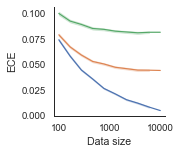

In [9]:
#df = results[results['temperature'].isin(['1', '1.5', '2', '2.5'])]
df = results
#ticks = df['Size'].unique()
ticks = [100, 1000, 10000] #df['Size'].unique()
rc = {'figure.figsize': (2, 2)}
font_scale = 1.1
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    #ylim=(-0.02,None),
    #xlim=(50,10000),
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Data size')
plot.legend([], [], frameon=False)
sns.despine(left=False, bottom=False)
plot.figure.savefig('plots/ece_sim.pdf', bbox_inches = "tight")

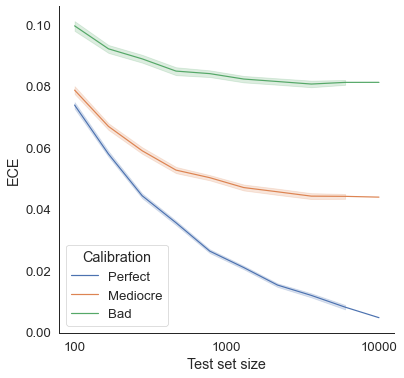

In [11]:
#df = results[results['temperature'].isin(['1', '1.5', '2', '2.5'])]
df = results
#ticks = df['Size'].unique()
ticks = [100, 1000, 10000] #df['Size'].unique()
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    #ylim=(-0.02,None),
    #xlim=(50,10000),
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
#plot.legend([], [], frameon=False)
sns.despine(left=False, bottom=False)